## 02 Ridership Time Series Forecasting - Online Learning
This notebook builds a machine learning time series forecasting model to predict demand of the Boston Bluebikes bikeshare system. We use an online learning algorithm that is able to analyze incoming data in real time and learn from this future data, improving the future prediction power.

### Notebook Objectives
1. Develop an online learning algorithm to build a ML time series model that can continuously update and learn from incoming data.

In [2]:
from pathlib import Path
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [7]:
# Load pickled dataframe of daily trip counts
daily = pd.read_pickle(Path('../assets/daily_df.pkl'))

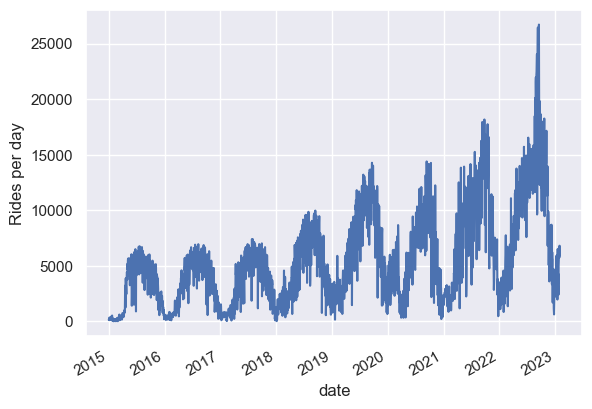

In [202]:
# Plot number of rides over the years
daily.plot()
plt.ylabel('Rides per day');

### Online Learning
With most time series data, we want to analyze incoming data in real time and update the machine learning model continuously. Let's build an online learning model that can do just that. We'll start with the custom Transformers developed in the previous notebook.

In [3]:
class QuadBackground(base.BaseEstimator, base.TransformerMixin):
    """Convert datetime to days and generate t and t^2 features"""
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        days = (X - self.X0).days
        return np.c_[days, days**2]


class FourierComponents(base.BaseEstimator, base.TransformerMixin):
    '''Return single Fourier term based on signal period'''

    def __init__(self, period):
        self.period = period
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        dt = (X - self.X0).days * 2 * np.pi / self.period
        return np.c_[np.sin(dt), np.cos(dt)]


class DayofWeek(base.BaseEstimator, base.TransformerMixin):
    '''One-hot encode day of week as categorical feature'''
    
    def fit(self, X, y=None):
        return self
    
    def day_vector(self, day):
        v = np.zeros(7)
        v[day] = 1
        return v
    
    def transform(self, X):
        return np.stack([self.day_vector(d) for d in X.dayofweek])


class IndexSelector(base.BaseEstimator, base.TransformerMixin):
    """Return indices of dataframe or Series for use in other estimators."""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.index


class ColumnSelector(base.BaseEstimator, base.TransformerMixin):
    """Return columns of dataframe for use in other estimators."""
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.cols]

In [4]:
# Pipeline setup

union = FeatureUnion([('drift', QuadBackground()),
                      ('fourier_1yr', FourierComponents(365)),
                      ('dayofweek', DayofWeek())])

time_pipe = Pipeline([('index', IndexSelector()),
                      ('features', union)])

full_union = FeatureUnion([('time_pipe', time_pipe),
                          ('columns', ColumnSelector(['previous', 'rolling']))
                          ])           

In [207]:
# Custom pipeline for online learning (default Pipeline class 
# does not support partial fits)

class PartialFitPipeline(Pipeline):
    
    def partial_fit(self, X, y):
        # Assume transformers without a partial_fit method can be skipped
        Xtrans = X
        for _, step in self.steps[:-1]:
            if hasattr(step, 'partial_fit'):
                step.partial_fit(Xtrans, y)
            Xtrans = step.transform(Xtrans)
        self.steps[-1][1].partial_fit(Xtrans, y)
        return self

sgd_pipe = PartialFitPipeline([('full_union', full_union),
                               ('scaler', StandardScaler()),
                               ('sgd', SGDRegressor(max_iter=100))])

Let's choose a split point for the initial training window. All data after the split point will be used in the online learning algorithm. At each step, the model will make a prediction about the incoming observation, then train the model with the new observation. Process is then repeated continuously.

In [210]:
split = 1000
daily_init = daily.iloc[:split]
daily_online = daily.iloc[split:]

In [211]:
# Let's create two new features: the previous day's count and a five-day rolling average
daily_init_df = pd.DataFrame({'counts': daily_init,
                              'previous': daily_init.shift(1).fillna(method='bfill'),
                              'rolling': daily_init.ewm(halflife=5).mean().shift(1).fillna(method='bfill')}) 

sgd_pipe.fit(daily_init_df, daily_init_df['counts'])
print(f"Training score: {sgd_pipe.score(daily_init_df, daily_init_df['counts'])}")

Training score: 0.8840680450971367


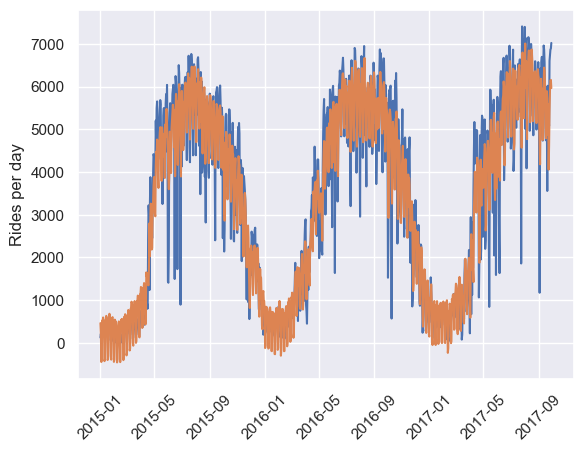

In [212]:
# Visualize fit on initial training window
plt.plot(daily_init, label='data')
plt.plot(daily_init.index, sgd_pipe.predict(daily_init_df), label='model')
plt.xticks(rotation=45);
plt.ylabel('Rides per day');

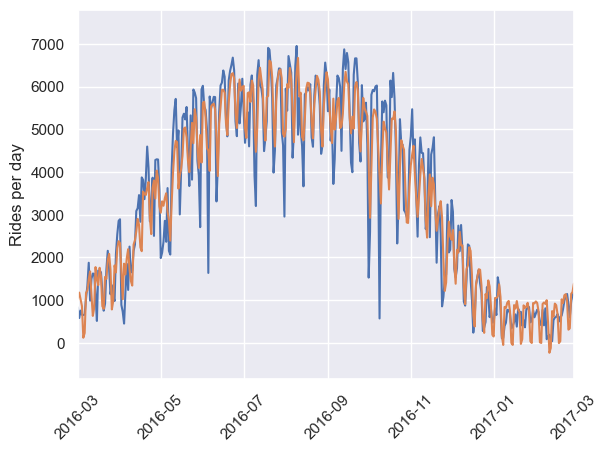

In [213]:
# Zoom in for inspection
plt.plot(daily_init, label='data')
plt.plot(daily_init.index, sgd_pipe.predict(daily_init_df), label='model')
plt.xlim(datetime.date(2016, 3, 1), datetime.date(2017, 3, 1))
plt.xticks(rotation=45);
plt.ylabel('Rides per day');

Now let's step forward through the online learning window. With each step, the model predicts the ride count for that day. The model is then trained on the new count observation and the updated model is used for the next step.

In [214]:
last_count = daily_init_df['counts'].iloc[-1]
alpha = 1 - 1./2**5
ewm = daily_init_df['rolling'].iloc[-1]
predictions = []
coefs = []

for date, count in daily_online.items():
    df = pd.DataFrame({'counts': count, 'previous': last_count, 'rolling': ewm}, index=[date])
    predictions.append(sgd_pipe.predict(df))
    sgd_pipe.partial_fit(df, df['counts'])
    coefs.append(sgd_pipe.named_steps['sgd'].coef_.copy())
    last_count = count
    ewm = alpha * count + (1 - alpha) * ewm

R^2 score: 0.8344435333009885


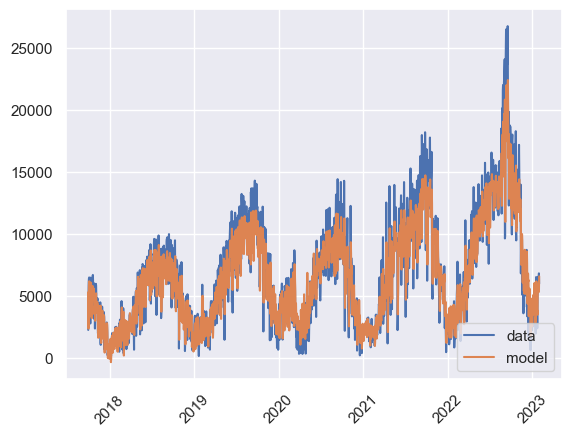

In [216]:
plt.plot(daily_online, label='data')
plt.plot(daily_online.index, predictions, label='model')
plt.legend(loc=4)
plt.xticks(rotation=45);
print(f"R^2 score: {r2_score(daily_online, predictions)}")

The $R^2$ score is quite good across the entire online window. Let's see how the $R^2$ changes during each step in the online learning process.

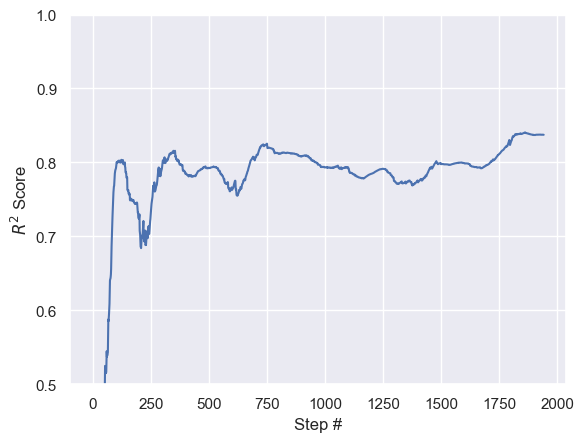

In [201]:
r2 = []
for i in range(5, len(daily_online)):
    r2.append(r2_score(daily_online[:i], predictions[:i]))

plt.plot(r2)
plt.ylim(0.5, 1.0)
plt.xlabel('Step #');
plt.ylabel('$R^2$ Score');


To see how the model is updating over time, let's look at the coefficients.

Last coefficients: [ 744.76236171  830.98828559 -583.25704547 -814.01635528  -65.13196875
  111.43080876  106.45930028   30.91546061   66.99612715   14.76177513
 -266.77484992 1534.00965785 1407.49352974]


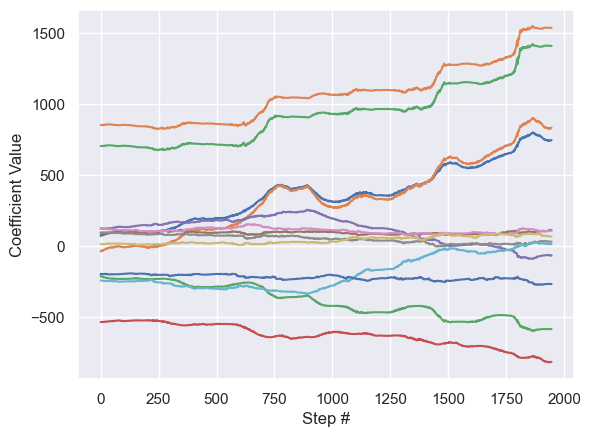

In [217]:
print(f"Last coefficients: {sgd_pipe.named_steps['sgd'].coef_}")

plt.plot(coefs);
plt.xlabel('Step #');
plt.ylabel('Coefficient Value');